In [1]:
%matplotlib widget

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models as m
from astropy.modeling.fitting import parallel_fit_dask, TRFLSQFitter

from ndcube import NDCube

/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides relative_to '/home/stuart/Git/astropy/astropy/_dev/scm_version.py'
  warnings.warn(


In [3]:
filename = Path("solo_L2_spice-n-ras_20230415T120519_V02_184549780-000.fits.gz")
window = 'N IV 765 ... Ne VIII 770 (Merged)'

In [4]:
if not filename.exists():
    import urllib.request
    urllib.request.urlretrieve(
        "https://soar.esac.esa.int/soar-sl-tap/data",
        filename=filename,
        data=b'retrieval_type=LAST_PRODUCT&data_item_oid=1446345&product_type=SCIENCE')

In [5]:
hdul = fits.open(filename)

In [6]:
hdu = hdul[window]

In [7]:
spice = NDCube(hdu.data, wcs=WCS(hdu), unit=hdu.header["BUNIT"], mask=np.isnan(hdu.data))

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 60049.503702 from DATE-OBS.
Set MJD-BEG to 60049.503702 from DATE-BEG.
Set MJD-AVG to 60049.542980 from DATE-AVG.
Set MJD-END to 60049.582254 from DATE-END'. [astropy.wcs.wcs]


In [8]:
spice

NDCube
------
Dimensions: [  1.  71. 834. 224.] pix
Physical Types of Axes: [('time',), ('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'time')]
Unit: W / (nm sr m2)
Data Type: >f4

In [9]:
spatial_mean = spice[0].rebin((1, 834, 224))[:, 0, 0]
spatial_mean

NDCube
------
Dimensions: [71.] pix
Physical Types of Axes: [('em.wl',)]
Unit: W / (nm sr m2)
Data Type: float64

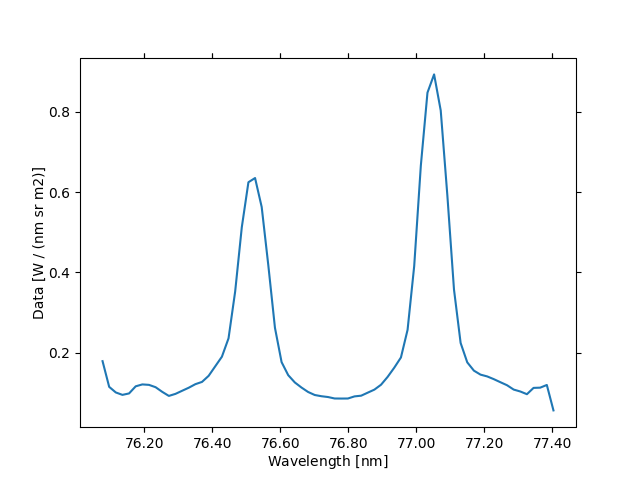

In [10]:
plt.figure()
ax = spatial_mean.plot()
ax.coords[0].set_format_unit("nm")
ax.coords[0].set_major_formatter("x.xx")

In [11]:
initial_model = (
    m.Const1D(amplitude=1 * spice.unit) +
    m.Gaussian1D(amplitude=1 * spice.unit, mean=764 * u.AA, stddev=0.5 * u.AA) +
    m.Gaussian1D(amplitude=1 * spice.unit, mean=769 * u.AA, stddev=0.5 * u.AA)
)
print(initial_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=1. W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=1. W / (nm sr m2), mean=764. Angstrom, stddev=0.5 Angstrom)>

    [2]: <Gaussian1D(amplitude=1. W / (nm sr m2), mean=769. Angstrom, stddev=0.5 Angstrom)>
Parameters:
     amplitude_0    amplitude_1    mean_1  stddev_1  amplitude_2    mean_2  stddev_2
    W / (nm sr m2) W / (nm sr m2) Angstrom Angstrom W / (nm sr m2) Angstrom Angstrom
    -------------- -------------- -------- -------- -------------- -------- --------
               1.0            1.0    764.0      0.5            1.0    769.0      0.5


In [12]:
fitter = TRFLSQFitter()
average_fit = fitter(
    initial_model,
    spatial_mean.axis_world_coords("em.wl")[0].to(u.AA),
    spatial_mean.data*spatial_mean.unit,
    filter_non_finite=True
)
print(average_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=0.30104603 W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=-0.23342925 W / (nm sr m2), mean=761.91394991 Angstrom, stddev=1.33132785 Angstrom)>

    [2]: <Gaussian1D(amplitude=-0.26418542 W / (nm sr m2), mean=767.73939517 Angstrom, stddev=0.90347906 Angstrom)>
Parameters:
        amplitude_0         amplitude_1      ...      stddev_2     
       W / (nm sr m2)      W / (nm sr m2)    ...      Angstrom     
    ------------------- -------------------- ... ------------------
    0.30104603227234644 -0.23342924742673324 ... 0.9034790614617065


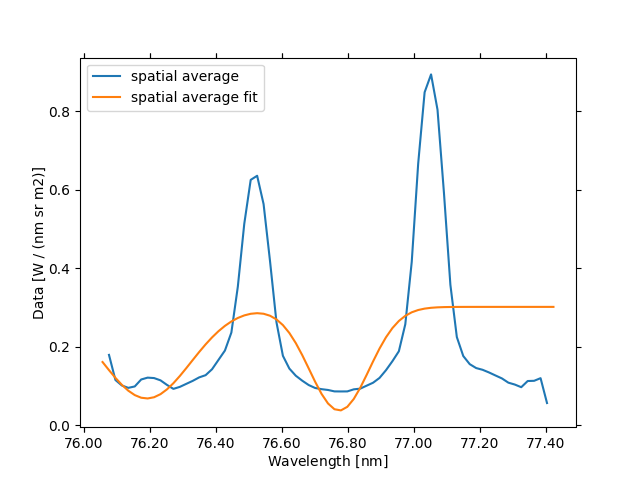

In [13]:
fig = plt.figure()
ax = spatial_mean.plot(label="spatial average")
ax.coords[0].set_format_unit("nm")
ax.coords[0].set_major_formatter("x.xx")
ax.plot(average_fit(spatial_mean.axis_world_coords("em.wl")[0]), label="spatial average fit")
plt.legend()

In [14]:
%%time

spice_model_fit = parallel_fit_dask(
    data=spice[0],
    model=average_fit,
    fitter=TRFLSQFitter(),
    fitting_axes=0,
    fitter_kwargs={"filter_non_finite": True}, # Filter out non-finite values
) 

/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides relative_to '/home/stuart/Git/astropy/astropy/_dev/scm_version.py'
  warnings.warn(
/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides relative_to '/home/stuart/Git/astropy/astropy/_dev/scm_version.py'
  warnings.warn(
/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides relative_to '/home/stuart/Git/astropy/astropy/_dev/scm_version.py'
  warnings.warn(
/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/setuptools_scm/_config.py:68: UserWarning: absolute root path '/home/stuart/Git/astropy/astropy' overrides 

CPU times: user 9.51 s, sys: 1min 6s, total: 1min 16s
Wall time: 2min 3s


In [15]:
wl_sum = spice[0].rebin((71, 1, 1), operation=np.sum)[0]

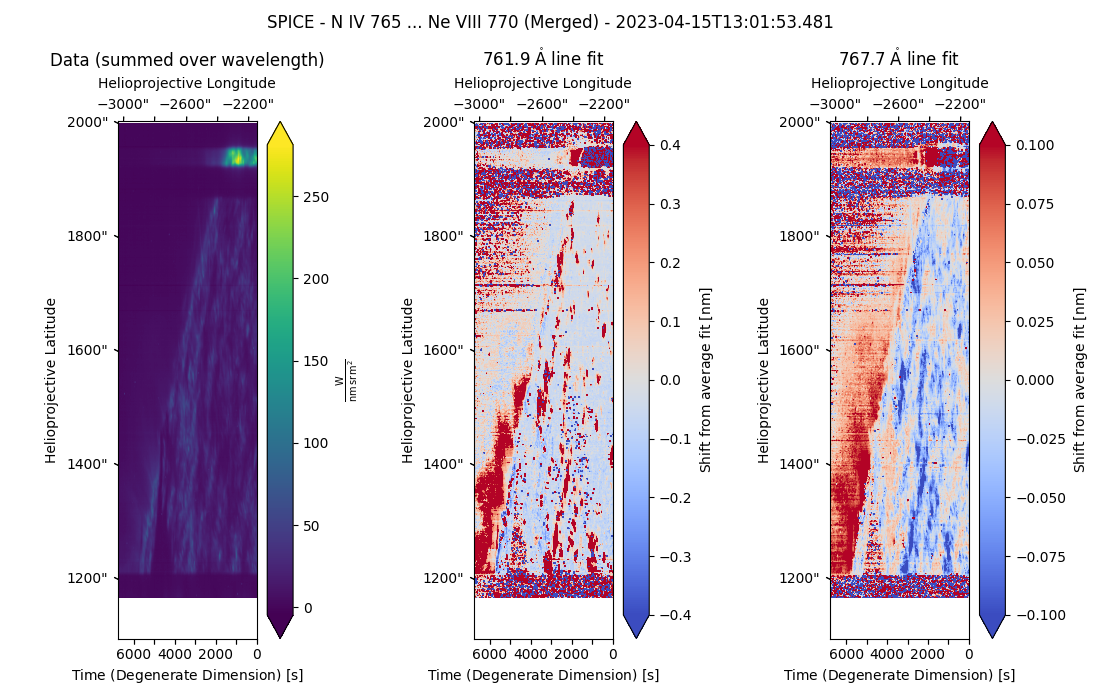

In [17]:
fig, axs = plt.subplots(ncols=3, subplot_kw=dict(projection=wl_sum), figsize=(11, 7))
fig.suptitle(f"SPICE - {hdu.header["EXTNAME"]} - {hdu.header["DATE-AVG"]}")

im = wl_sum.plot(axes=axs[0])
fig.colorbar(axs[0].get_images()[0], ax=axs[0], extend="both", label=f"{wl_sum.unit:latex}")
axs[0].set_title("Data (summed over wavelength)", pad=40)

mean_1 = axs[1].imshow((average_fit.mean_1 - spice_model_fit.mean_1).to_value(u.nm), vmin=-0.4, vmax=0.4, cmap="coolwarm")
fig.colorbar(mean_1, ax=axs[1], extend="both", label=f"Shift from average fit [{u.nm:latex}]")
axs[1].set_title(f"{average_fit.mean_1.quantity.round(1):latex} line fit", pad=40)

mean_2 = axs[2].imshow((average_fit.mean_2 - spice_model_fit.mean_2).to_value(u.nm), vmin=-0.1, vmax=0.1, cmap="coolwarm")
fig.colorbar(mean_2, ax=axs[2], extend="both", label=f"Shift from average fit [{u.nm:latex}]")
axs[2].set_title(f"{average_fit.mean_2.quantity.round(1):latex} line fit", pad=40)

for ax in axs:
    ax.coords[0].set_ticklabel(exclude_overlapping=True)
    ax.coords[0].set_axislabel("Helioprojective Longitude")
    ax.coords[1].set_axislabel("Helioprojective Latitude")
    ax.coords[2].set_ticklabel(exclude_overlapping=True)

fig.tight_layout()